# Classification of YouTube comments as Spam or Non-Spam 

#### With the advancement of intelligent bots, Spam comments have been commonplace for quite sometime in mainstream softwares like YouTube. My project explores how to develop a machine learning model, more specifically a RandomForest classifier that can predict whether a comment is spam or non-spam, given a particular input vector of data. 

#### The main steps to follow
1. Choosing a suitable dataset - https://www.kaggle.com/datasets/ahsenwaheed/youtube-comments-spam-dataset
I used this dataset to train my classifier.
2. Preprocessing data - This dataset has duplicate values and missing values. Also, some features have to be encoded and the 'CONTENT' column has to be vectorized.
3. Training the model - Selecting an appropriate model for training. 
4. Evaluation of the model - Using evaluation metrics for classification models.
5. Re-tuning hyperparameters till an acceptable optimum result is obtained - Varying hyperparameter values.

In [2]:
import pandas as pd #for dataframe manipulations
import numpy as np  #for efficient math operations
from sklearn.feature_extraction.text import CountVectorizer #To vectorize text
import matplotlib.pyplot as plt #For plotting
from sklearn.preprocessing import LabelEncoder #For label encoding
from sklearn.model_selection import train_test_split #For train test splitting
from sklearn.ensemble import RandomForestClassifier #For Random Forest model training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix as c_m

#### Preprocessing Data

1. Removing rows with missing values
2. Removing duplicate rows
3. Label Encoding
4. Removing unnecessary features
 
5. Vectorizing  the 'Content' column

In [33]:
def data_cleaning_encoding(data):
    """Performs data cleaning operations (Removal of null/missing values and duplicates)

    Args:
        data (Pandas DataFrame): The initial DataFrame that holds data

    Returns:
        Pandas DataFrame: The cleaned DataFrame
    """

    #Handling missing/null values
    if data.isnull().any(axis=1).any():  #checking for rows with null/missing values
        null_rows = data[data.isnull().any(axis=1)]
        print(f"Found {len(null_rows)} rows with null values.. Removing them...")
        data.dropna(inplace=True)  #removing rows with null values

    #Handling duplicates
    if data.duplicated().any():  #checking for duplicate rows
        dup_rows = data[data.duplicated()]
        print(f"Found {len(dup_rows)} duplicate rows.. Removing them...")
        data.drop_duplicates(inplace=True) #removing duplicate rows

    #Encoding String columns
    le = LabelEncoder()
    data["AUTHOR"] = le.fit_transform(data["AUTHOR"])
    data["VIDEO_NAME"] = le.fit_transform(data["VIDEO_NAME"])

    #Removing unnecessary features
    data.drop(["DATE"], axis=1, inplace=True)
    data.drop(["COMMENT_ID"], axis=1, inplace=True)

    #Reset index after cleaning 
    #Resetting the index is essential as this cleaned dataframe is concatanted with the vectorized dataframe in the next vectorizing function.
    #Otherwise when merging the 2 dataframes, indices misalign and introduce new NaN values.
    data.reset_index(drop=True, inplace=True)

    #print(data.isnull().sum())  #debug statement 
    return data

In [34]:
def vectorizing(cleaned_data): #https://medium.com/@divyansh3021/text-vectorization-transforming-words-into-meaningful-representations-e03b31bb3cb3
    """Performs vectorization operations

    Args:
        cleaned_data (Pandas DataFrame): A cleaned DataFrame 

    Returns:
        Pandas DataFrame: The cleaned + feature vectorized DataFrame
    """
    feature_to_vectorize = cleaned_data['CONTENT']
    vectorizer = CountVectorizer() #Initializing the vectorizer

    #vectorizer.fit_transform returns a sparse matrix (only non zero elements are stored). To convert it to a dense array, use toarray()
    #Then it is easier to transform the vectorized array into a dataframe
    vectorized_feature_array = vectorizer.fit_transform(feature_to_vectorize).toarray() 

    vectorized_df = pd.DataFrame(vectorized_feature_array, columns=vectorizer.get_feature_names_out()) #Transforming the vectorized Dense array into a dataframe

    # Reset indices to ensure alignment
    # This is a defensive programming step to re-ensure that the indices of the two dataframes are aligned before concatenation
    vectorized_df.reset_index(drop=True, inplace=True)
    cleaned_data.reset_index(drop=True, inplace=True)

    # Concatenate the two dataframes
    combined_data = pd.concat([cleaned_data, vectorized_df], axis=1)

    #print(combined_data.isnull().sum()) #debug statement
    return combined_data

#### Training a classification model (RandomForest)

In [35]:
def train_test_splitting(data, test_size=0.3):
    """Performs train test splitting

    Args:
        data (Pandas DataFrame): Preprocessed DataFrame

    Returns:
        (Pandas DataFrame, Pandas DataFrame, Pandas DataFrame, Pandas DataFrame): The train and test dataframes
    """
    
    x = data.drop(["CLASS","CONTENT"], axis=1) #The content column is of no use after vectorization
    y = data["CLASS"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    return x_train, x_test, y_train, y_test

In [36]:
def model_training_random_forest(x_train, y_train, n_estimators, max_depth, max_features):
    """Performs model training

    Args:
        x_train (Pandas DataFrame): Training examples
        y_train (Pandas DataFrame): Training labels
        n_estimators (int): Number of estimators
        max_depth (int): Maximum depth of trees
        max_features (int|double): Maximum number of features to consider when looking for the best split

    Returns:
        RandomForestClassifier: A trained model
    """
    
    model = RandomForestClassifier(criterion='entropy', random_state=42, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    model.fit(x_train, y_train)

    return model

#### Model Evaluation 

In [37]:
def model_evaluation_scores(y_pred, y_test):
    """Performs model evaluation using metrics such as accuracy, precision, recall, f1

    Args:
        y_pred (NumPy array): Predicted labels
        y_test (Pandas DataFrame): Testing labels

    Returns:
        (float, float, float, float): Evaluation metrics (accuracy, precision, recall, f1)
    """
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

In [38]:
def confusion_matrix(y_pred, y_test):
    """Plots confusion matrix

    Args:
        y_pred (NumPy array): Predicted labels
        y_test (Pandas DataFrame): Testing labels

    """
    cm = c_m(y_test, y_pred)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SPAM', 'NON-SPAM'])
    cmp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [39]:
def classification_rep(y_pred, y_test):
    """Generates the classification report

    Args:
        y_pred (Numpy array): Predicted labels
        y_test (Pandas Dataframe): Testing labels
    """
    print(classification_report(y_test, y_pred, target_names=['SPAM', 'NON-SPAM']))

#### Running the training and evaluation process

Found 245 rows with null values.. Removing them...
Found 1 duplicate rows.. Removing them...


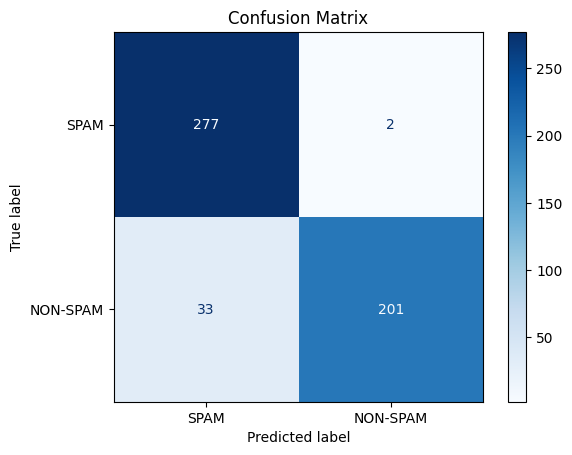

              precision    recall  f1-score   support

        SPAM       0.89      0.99      0.94       279
    NON-SPAM       0.99      0.86      0.92       234

    accuracy                           0.93       513
   macro avg       0.94      0.93      0.93       513
weighted avg       0.94      0.93      0.93       513

Accuracy: 0.9317738791423001
Precision: 0.9901477832512315
Recall: 0.8589743589743589
F1: 0.919908466819222


In [44]:
def main():
    data = pd.read_csv('Youtube-Spam-Dataset.csv')
    data = data_cleaning_encoding(data)
    #print(data.shape) #debug statement
    data = vectorizing(data)
    #print(data.shape) #debug statement

    x_train, x_test, y_train, y_test = train_test_splitting(data)
    model = model_training_random_forest(x_train, y_train, n_estimators=160, max_depth=20, max_features='sqrt')

    y_pred = model.predict(x_test)  

    accuracy, precision, recall, f1 = model_evaluation_scores(y_pred, y_test)

    confusion_matrix(y_pred, y_test)

    classification_rep(y_pred, y_test)

    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}") 

if __name__ == "__main__":
    main()